In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal
from scipy.interpolate import CubicSpline
import mpl_axes_aligner 
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib widget

In [22]:
# data=pd.read_csv("not_moving_trot.csv")
# table=data[7500:]

#files are named gait-speed-period
data=pd.read_csv("trot-1-0.4.csv")
table=data
print(len(table.index))

holder=[]
for i in range(len(table.index)):
    holder.append(table.qd00[i]*table.t00[i])
table.insert(len(table.columns), "p00", holder, True)
holder=[]
for i in range(len(table.index)):
    holder.append(table.qd01[i]*table.t01[i])
table.insert(len(table.columns), "p01", holder, True)
holder=[]
for i in range(len(table.index)):
    holder.append(table.qd02[i]*table.t02[i])
table.insert(len(table.columns), "p02", holder, True)


20662


,time,iterations,bodyOrientation0,bodyOrientation1,bodyOrientation2,bodyOrientation3,vb0,rpy0,omegab0,omega0,...,qd31,qdd31,t31,q32,qd32,qdd32,t32,p00,p01,p02
0,20.000,10000,0.999905,-0.001358,-0.005193,-0.012661,1.02032,-0.002584,1.158840,1.184960,...,0.731095,824.7290,5.62339,1.43355,-4.773870,-886.581,-4.34183,-3.289704,-8.003239,1.156448
1,20.001,10001,0.999909,-0.000750,-0.004646,-0.012651,1.02272,-0.001383,1.201010,1.228460,...,0.200185,743.3280,5.05020,1.42931,-4.240760,-837.972,-4.14147,-3.356909,-7.997171,0.974043
2,20.002,10001,0.999912,-0.000140,-0.004083,-0.012640,1.02428,-0.000178,1.205520,1.233860,...,0.270505,740.5660,5.02284,1.42501,-4.297060,-841.119,-4.16113,-3.393431,-8.126989,0.859342
3,20.003,10002,0.999914,0.000472,-0.003501,-0.012630,1.02569,0.001032,1.209550,1.238810,...,0.343668,740.0230,5.00726,1.42066,-4.355160,-836.909,-4.13642,-3.410925,-8.120297,0.740857
4,20.004,10002,0.999916,0.001109,-0.002896,-0.012623,1.02623,0.002290,1.258200,1.288640,...,0.436704,776.9760,5.32506,1.41623,-4.426860,-823.264,-4.01102,-2.919790,-6.188051,2.562306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20657,40.657,20328,0.999879,-0.010521,0.010336,-0.004863,1.01809,-0.021145,-0.058494,-0.059594,...,-4.364570,-95.1653,-1.77391,1.49811,1.816240,-1150.570,-6.98826,-0.015526,7.510483,-9.904106
20658,40.658,20329,0.999880,-0.010558,0.010234,-0.004847,1.01691,-0.021219,-0.074105,-0.075440,...,-4.390670,-92.8194,-1.75532,1.49995,1.834800,-1152.530,-6.99765,0.031947,7.456349,-9.539405
20659,40.659,20329,0.999881,-0.010625,0.010110,-0.004836,1.01644,-0.021352,-0.133327,-0.135273,...,-4.491960,-73.6867,-1.63986,1.50063,0.681216,-1155.190,-6.99410,0.168978,6.898437,-8.938463
20660,40.660,20330,0.999882,-0.010647,0.010002,-0.004823,1.01581,-0.021394,-0.042835,-0.044409,...,-4.286750,-72.6035,-1.60511,1.50216,1.527750,-1116.880,-6.75389,0.414767,6.847084,2.581877


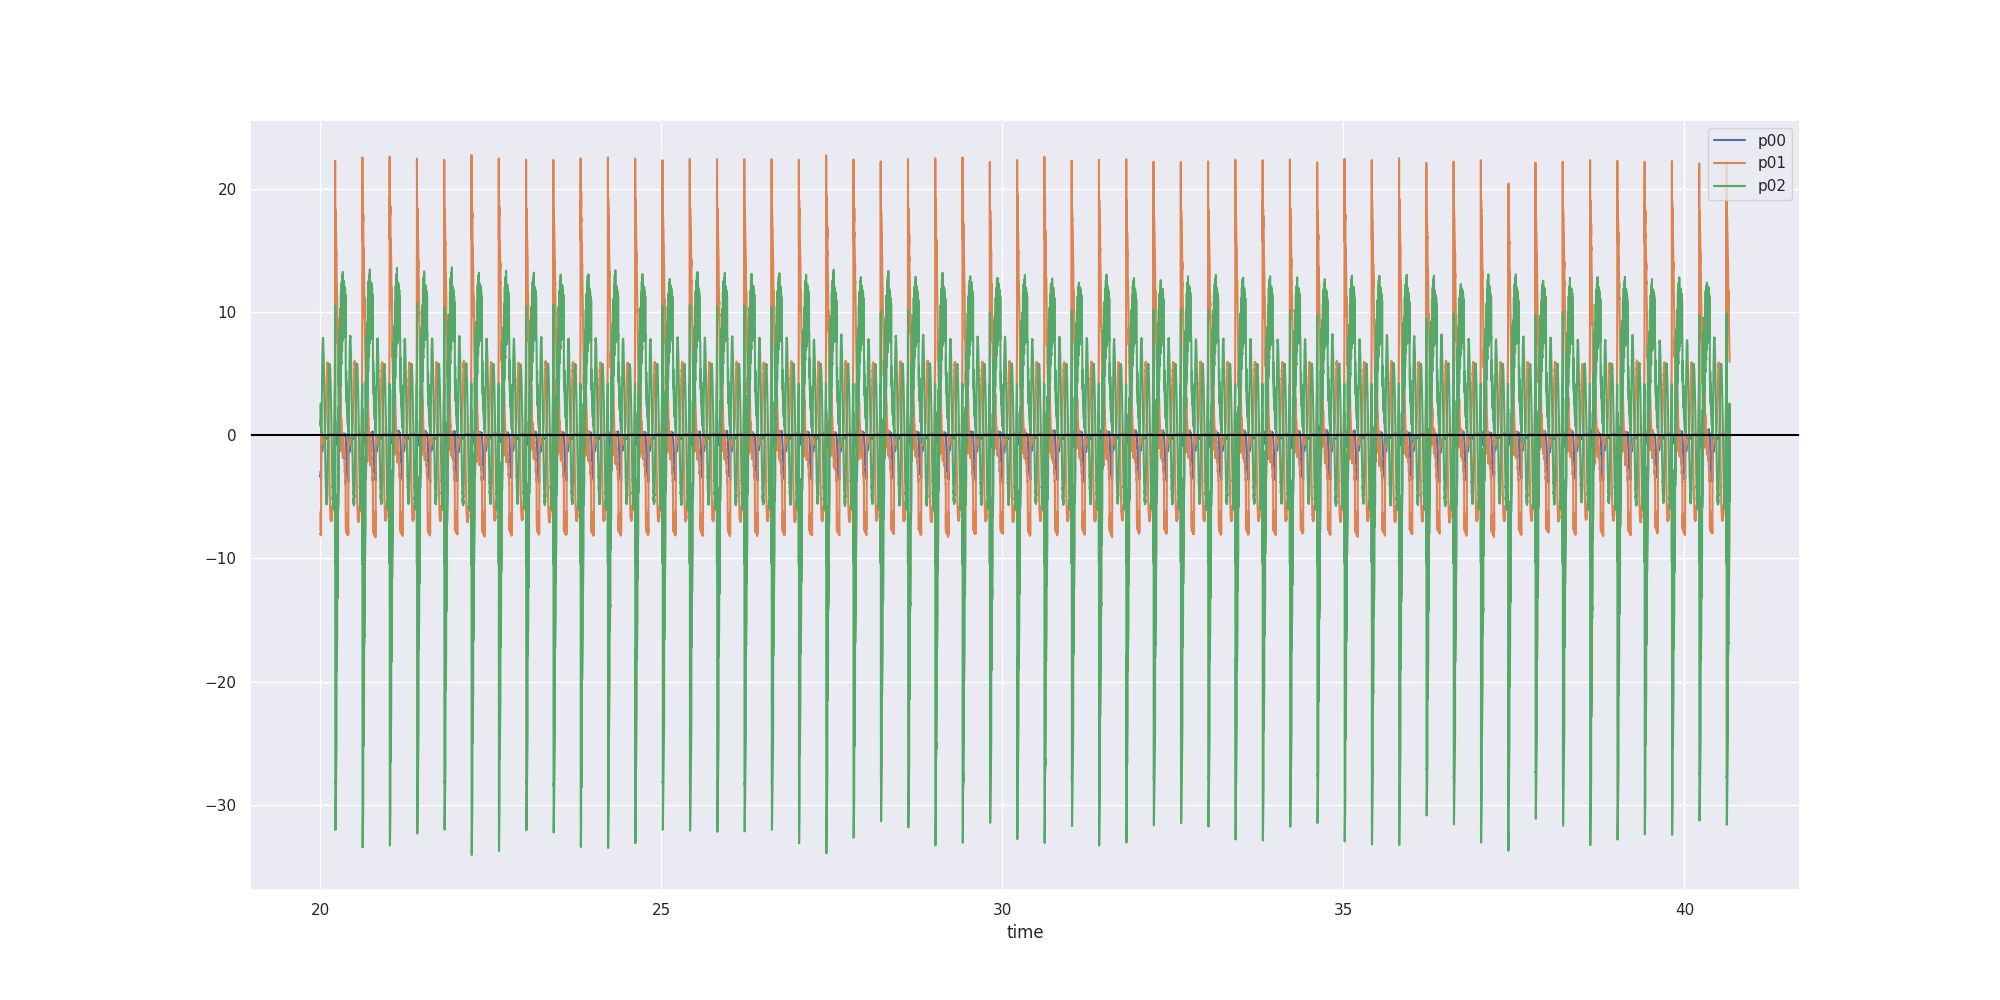

In [31]:
plt.close()
plt.figure(figsize=(20,10))
ax = plt.gca()

# table.plot( x = 'time' , y = 'q01', ax = ax )
table.plot( x = 'time' , y = 'p00', ax = ax )
table.plot( x = 'time' , y = 'p01', ax = ax )
table.plot( x = 'time' , y = 'p02', ax = ax )
# table.plot( x = 'time' , y = 'p02', ax = ax )
# table.plot( x = 'time' , y = 'qd00', ax = ax )
# table.plot( x = 'time' , y = 't00', ax = ax )
# table.plot( x = 'time' , y = 't01', ax = ax )

plt.axhline(y=0.0, color='black', linestyle='-')

plt.show()

In [5]:
def calculate_areas(start,end):
    positive_area=[0.0,0.0,0.0]
    negative_area=[0.0,0.0,0.0]
    time=0.001
    columns=['p00','p01','p02']
    for jj in range(3):
        for i in range(end-start):
            first_area=0.0
            second_area=0.0
            # print(table.p01[i+start],"  ",table.p01[i+start+1])
            if(table.loc[i+start,columns[jj]]>=0.0 and table.loc[i+start+1,columns[jj]]>=0.0):
                positive_area[jj]+=(table.loc[i+start,columns[jj]]+table.loc[i+start+1,columns[jj]])*time/2
            elif(table.loc[i+start,columns[jj]]<0.0 and table.loc[i+start+1,columns[jj]]<0.0):
                negative_area[jj]+=(table.loc[i+start,columns[jj]]+table.loc[i+start+1,columns[jj]])*time/2
            else:
                intersect=table.loc[i+start,columns[jj]]/(table.loc[i+start,columns[jj]]-table.loc[i+start+1,columns[jj]])*time
                first_area=table.loc[i+start,columns[jj]]*intersect/2
                second_area=table.loc[i+start+1,columns[jj]]*(time-intersect)/2
                if(first_area >=0.0):
                    positive_area[jj]+=first_area
                    negative_area[jj]+=second_area
                else:
                    positive_area[jj]+=second_area
                    negative_area[jj]+=first_area
    return positive_area,negative_area

In [6]:
def analyze_areas(start,end):
    min_power=[0.0,0.0,0.0]
    max_power=[0.0,0.0,0.0]
    start_window=[0,0,0]
    end_window=[0,0,0]
    max_neg_energy=[99999.9,99999.0,99999.0]
    time=0.001
    columns=['p00','p01','p02']
    for jj in range(3):
        temp_holder=0
        tmp_start=0
        tmp_end=0;
        for i in range(end-start):
            first_area=0.0
            second_area=0.0
            # print(table.p01[i+start],"  ",table.p01[i+start+1])
            if(table.loc[i+start,columns[jj]]>=0.0 and table.loc[i+start+1,columns[jj]]>=0.0):
                if( max_neg_energy[jj] > temp_holder):
                    max_neg_energy[jj]=temp_holder
                    start_window[jj]=tmp_start
                    end_window[jj]=tmp_end
                temp_holder=0
                tmp_start=i+start
            elif(table.loc[i+start,columns[jj]]<0.0 and table.loc[i+start+1,columns[jj]]<0.0):
                temp_holder+=(table.loc[i+start,columns[jj]]+table.loc[i+start+1,columns[jj]])*time/2
                tmp_end=i+start+1
            else:
                intersect=table.loc[i+start,columns[jj]]/(table.loc[i+start,columns[jj]]-table.loc[i+start+1,columns[jj]])*time
                first_area=table.loc[i+start,columns[jj]]*intersect/2
                second_area=table.loc[i+start+1,columns[jj]]*(time-intersect)/2
                if(first_area >=0.0):
                    if( max_neg_energy[jj] > temp_holder):
                        max_neg_energy[jj]=temp_holder
                        start_window[jj]=tmp_start
                        end_window[jj]=tmp_end
                    temp_holder=0
                    tmp_start=i+start
                    temp_holder+=second_area
                    tmp_end=i+start+1
                else:
                    temp_holder+=first_area
                    tmp_end=i+start+1
                    if( max_neg_energy[jj] > temp_holder):
                        max_neg_energy[jj]=temp_holder
                        start_window[jj]=tmp_start
                        end_window[jj]=tmp_end
                    temp_holder=0
                    tmp_start=i+start
        if( max_neg_energy[jj] > temp_holder):
            max_neg_energy[jj]=temp_holder
            start_window[jj]=tmp_start
            end_window[jj]=tmp_end
    return max_neg_energy,start_window,end_window

In [29]:
def analyze_range(start,end,period):
    peaks, _ = find_peaks(table['p01'], height=20,distance=200)
    filtered_data=peaks[(peaks >= start) & (peaks <= end)]
    # print(filtered_data)
    # print(len(filtered_data))
    
    max_neg_energy=[0.0,0.0,0.0]
    neg_energy=[0.0,0.0,0.0]
    pos_energy=[0.0,0.0,0.0]
    window=[0,0,0]
    for tmprng in range(len(filtered_data)-1):
        # print(tmprng)
        if(filtered_data[tmprng+1]-filtered_data[tmprng+1]+50)>period:
            raise Exception("SOMETHING WRONG")
            
        a,b=calculate_areas(filtered_data[tmprng],filtered_data[tmprng+1])
        c,d,e=analyze_areas(filtered_data[tmprng],filtered_data[tmprng+1])
        for ii in range(3):
            pos_energy[ii]+=a[ii]
            neg_energy[ii]+=b[ii]
            max_neg_energy[ii]+=c[ii]
            window[ii]+=(e[ii]-d[ii])
            print(e[ii]-d[ii])
    # max_neg_energy/=len(filtered_data)
    # neg_energy/=len(filtered_data)
    # pos_energy/=len(filtered_data)
    for ii in range(3):
            pos_energy[ii]=pos_energy[ii]/(len(filtered_data)-1)
            neg_energy[ii]=neg_energy[ii]/(len(filtered_data)-1)
            max_neg_energy[ii]=max_neg_energy[ii]/(len(filtered_data)-1)
            window[ii]=window[ii]/(len(filtered_data)-1)
    print(max_neg_energy)
    print(pos_energy)
    print(neg_energy)
    print(window)
    plt.close()
    plt.figure(figsize=(20,10))
    ax = plt.gca()
    plt.plot(table['p01'])
    plt.plot(filtered_data, table['p01'][filtered_data], 'ro')  # 'ro' stands for red dots at peak locations
    plt.title('Data with Peaks Above Threshold')
    plt.show()

# analyze_range(12300,15000)

47
79
42
52
79
48
156
79
46
52
79
45
49
79
40
157
79
48
158
79
46
160
79
44
157
79
44
152
79
43
52
79
49
50
79
45
157
79
44
54
79
43
54
79
43
53
79
44
161
79
43
48
79
46
49
79
40
48
79
47
158
79
40
48
79
40
157
79
46
47
79
43
47
79
41
152
79
43
53
79
44
155
79
43
156
79
50
161
79
44
161
79
43
53
79
44
158
79
43
160
79
43
52
79
48
165
79
44
152
79
39
155
79
48
49
79
40
48
78
42
160
78
39
155
79
43
154
79
48
48
78
17457
47
79
42
52
79
44
50
79
50
49
79
40
53
79
47
[-0.11322903040781417, -0.3889084974197811, -0.8607348098917781]
[0.012060092782472248, 0.961722753159967, 1.2034113382411344]
[-0.15174452732168253, -0.8146631490318905, -1.2305772219865718]
[100.42857142857143, 78.93877551020408, 399.3469387755102]


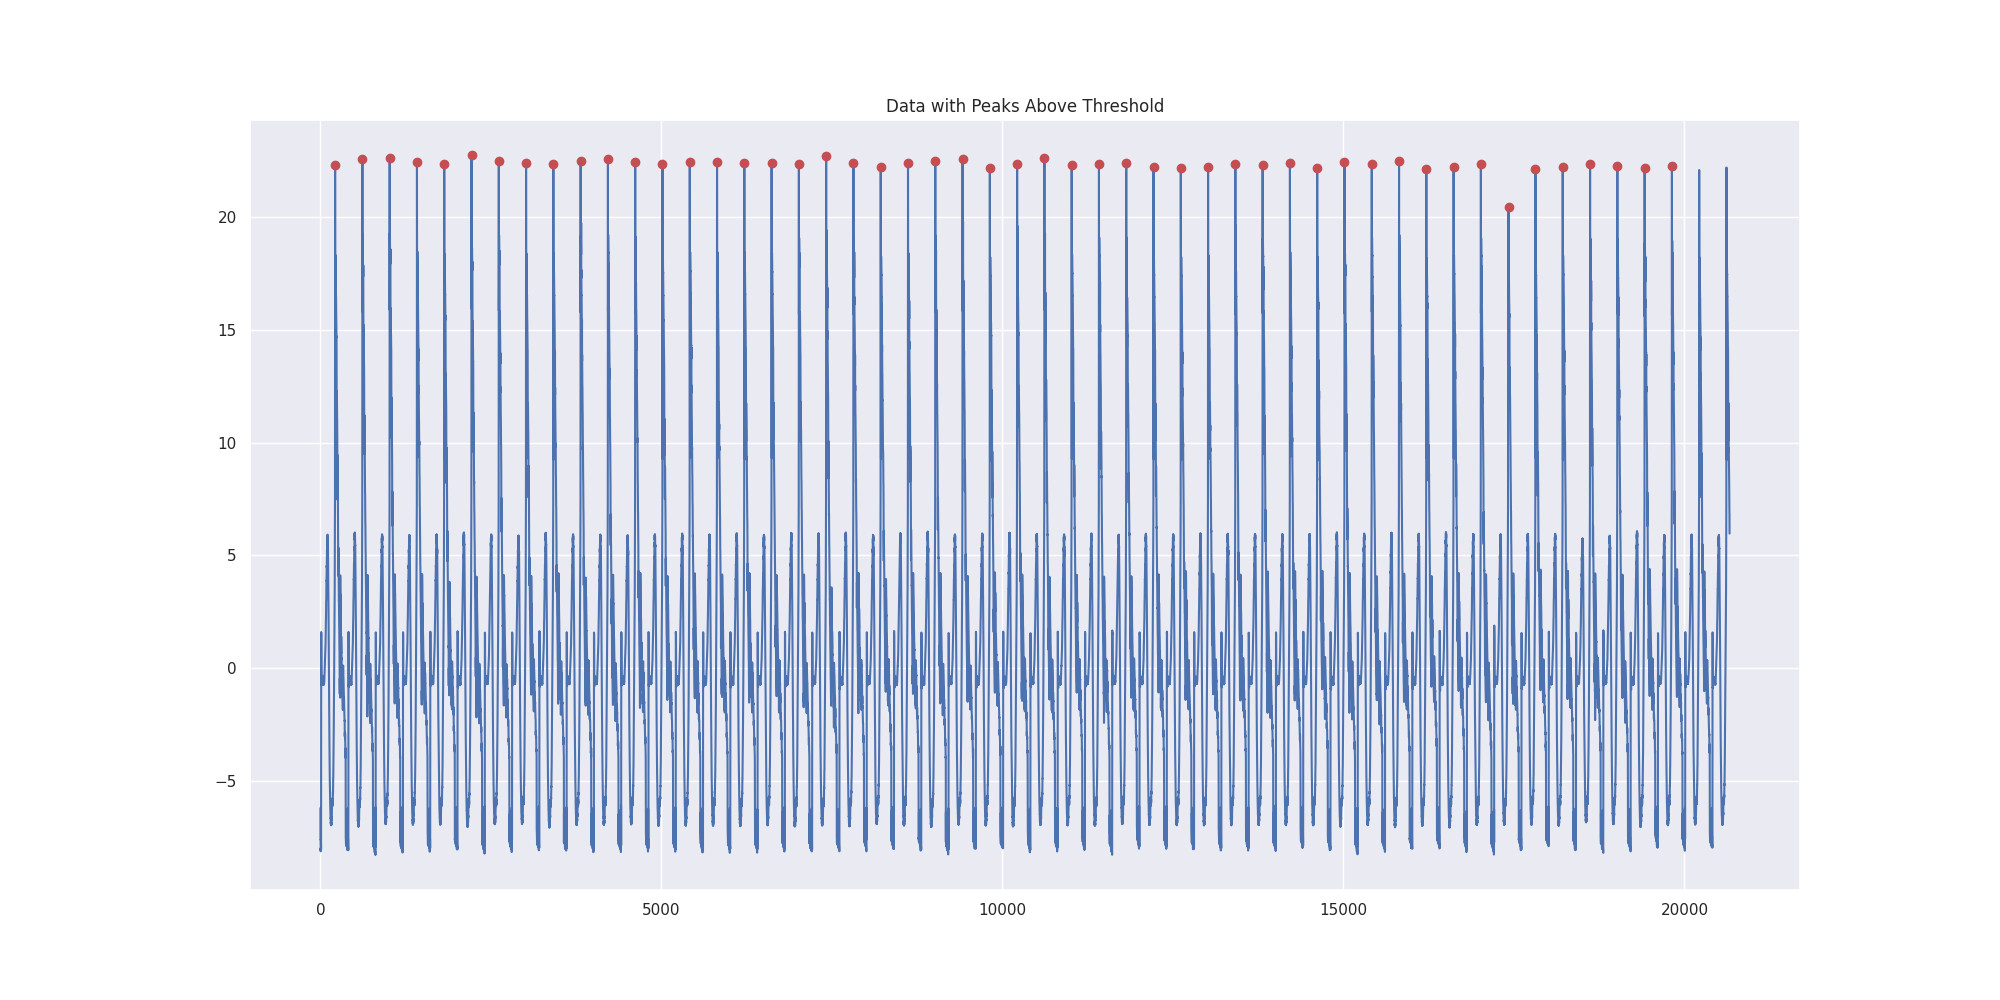

In [30]:
# positive_energy,negative_energy=calculate_areas(0,20000)
# max_neg_energy,start_window,end_window=analyze_areas(0,20000)
analyze_range(0,20000,300)
# print(positive_energy)
# print(negative_energy)
# print(max_neg_energy)
# print(start_window)
# print(end_window)


In [8]:
# plt.close()
# plt.figure(figsize=(20,10))
# ax = plt.gca()
# peaks, _ = find_peaks(-table['p01'], height=500,distance=200)
# plt.plot(table['p01'])
# plt.plot(peaks, table['p01'][peaks], 'ro')  # 'ro' stands for red dots at peak locations
# plt.title('Data with Peaks Above Threshold')
# plt.show()
# peaks